# The Problem

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive the titanic than others.

You are asked to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

# Prerequisites

Here are the most popular packages we are going to use in our Data Preparation
- Numpy for handling large dimensional arrays
- Pandas for data manipulation and analysis
- Matplotlib for building data visualizations
- Seaborn: Built on top of matplotlib, makes building graphs a bit easier and more colorful.
- Scikit-learn: for Machine Learning Algorithms.


In [1]:
# Load libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.cluster import KMeans

# Data 

Starting with the Data Dictionary:

In [2]:
df_dict =pd.read_excel('Data Dictionary.xlsx')
df_dict

,Variable,Definition,Key
0,survival,Survival,"0 = No, 1 = Yes"
1,pclass,Ticket class,"1 = 1st, 2 = 2nd, 3 = 3rd"
2,sex,Sex,NaN
3,Age,Age in years,NaN
4,sibsp,# of siblings / spouses aboard the Titanic,NaN
5,parch,# of parents / children aboard the Titanic,NaN
6,ticket,Ticket number,NaN
7,fare,Passenger fare,NaN
8,cabin,Cabin number,NaN
9,embarked,Port of Embarkation,"C = Cherbourg, Q = Queenstown, S = Southampton"


### Variable Notes
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...  
- Sibling = brother, sister, stepbrother, stepsister  
- Spouse = husband, wife (mistresses and fiancés were ignored)  

parch: The dataset defines family relations in this way...  
- Parent = mother, father  
- Child = daughter, son, stepdaughter, stepson  
- Some children travelled only with a nanny, therefore parch=0 for them.  

# Load Data

In [3]:
# Load training data
training_data = pd.read_csv('train.csv')

# Load testing data
testing_data = pd.read_csv('test.csv')

In [4]:
training_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Data Exploration Analysis (EDA)

Inspect variable types:

In [5]:
training_data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Sometimes, integer variables are cast as float. 
So, even if you get float as the type, check the unique values to see if those variables are discrete or continuous.

In [6]:
training_data['Fare'].unique()[0:10]

array([ 7.25  , 71.2833,  7.925 , 53.1   ,  8.05  ,  8.4583, 51.8625,
       21.075 , 11.1333, 30.0708])

We can use histograms to show frequency distribution of the features we have, where it can also be used to understand if the variable is discrete or continuous

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000209870A42C8>,
      dtype=object)

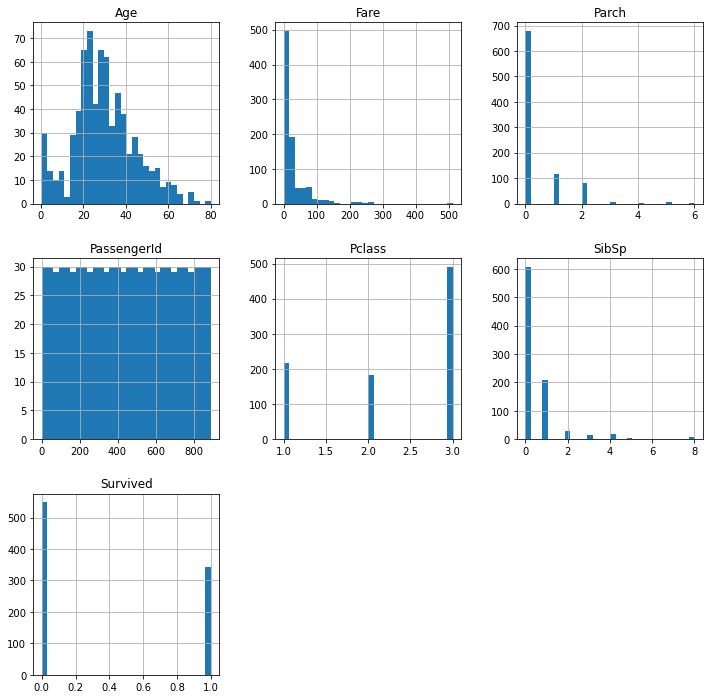

In [7]:
training_data.hist(bins=30, figsize=(12,12))

We can find the cardinality in categorical features easily by finding the number of unique value

In [8]:
training_data.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

Visualize the cardinality:

Text(0.5, 1.0, 'Cardinality')

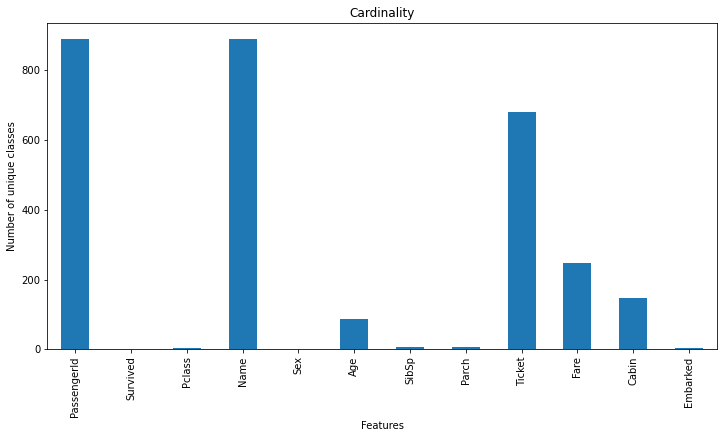

In [9]:
training_data.nunique().plot.bar(figsize=(12,6))
plt.ylabel('Number of unique classes')
plt.xlabel('Features')
plt.title('Cardinality')

View the percentage of each class in the feature

In [10]:
class_freq = (training_data['Sex'].value_counts() / training_data['Sex'].count()) * 100
class_freq

male      64.758698
female    35.241302
Name: Sex, dtype: float64

We can use a bar chart to visualize the frequency of each class and identify imbalance

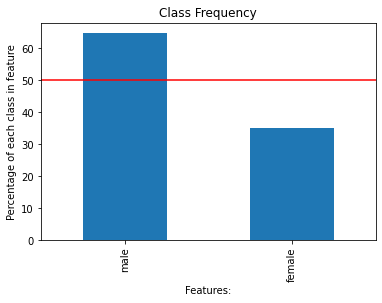

In [11]:
fig = class_freq.plot.bar()
fig.axhline(y=50, color='red')
fig.set_ylabel('Percentage of each class in feature')
fig.set_xlabel('Features:')
fig.set_title('Class Frequency')
plt.show()

Next, Let's check how many missing values we have

In [12]:
training_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

We can also see the percentages of missing values per features

In [13]:
training_data.isnull().mean()

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

We can use a bar chart to visualize the numbers

Text(0.5, 1.0, 'Missing Data')

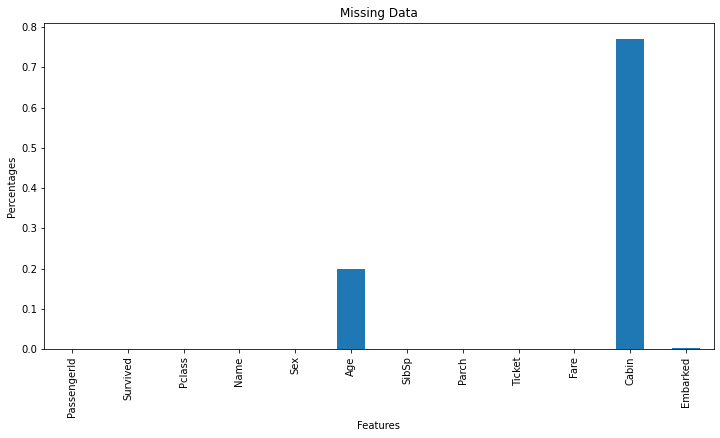

In [14]:
training_data.isnull().mean().plot.bar(figsize=(12,6))
plt.ylabel('Percentages')
plt.xlabel('Features')
plt.title('Missing Data')

Lets drop PassengerId feature as we can get no information from it.  
Since we have 77% of the feature Cabin missing, lets go ahead and drop it too.
We also saw that Ticket and Name have high cardinality, so we can drop them too

In [15]:
training_data.drop(columns=['PassengerId','Cabin','Name','Ticket'], inplace=True)

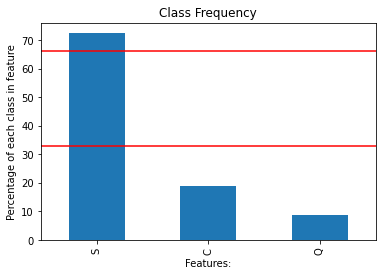

In [16]:
class_freq = (training_data['Embarked'].value_counts() / training_data['Embarked'].count()) * 100
fig = class_freq.plot.bar()
fig.axhline(y=33, color='red')
fig.axhline(y=66, color='red')
fig.set_ylabel('Percentage of each class in feature')
fig.set_xlabel('Features:')
fig.set_title('Class Frequency')
plt.show()

Since Embarked is categorical, we can try filling it with the most frequent class, in this case it is "S"

In [17]:
training_data[training_data['Embarked'].isnull().values]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
61,1,1,female,38.0,0,0,80.0,NaN
829,1,1,female,62.0,0,0,80.0,NaN


In [18]:
training_data['Embarked']=training_data['Embarked'].replace(np.nan,'S')
training_data[training_data['Embarked'].isnull().values]

# We can also use the below line of code to drop the rows that
# training_data.dropna(subset=['Embarked'])

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked


Now let's check the statistics for all features

In [19]:
training_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


We can choose to zoom in on different classes in a feature or multiple features and obtain statistics for them using the groupby() function 

In [20]:
training_data.groupby(['Sex']).mean()

,Survived,Pclass,Age,SibSp,Parch,Fare
Sex,,,,,,
female,0.742038,2.159236,27.915709,0.694268,0.649682,44.479818
male,0.188908,2.389948,30.726645,0.429809,0.235702,25.523893


In [21]:
training_data.groupby(['Sex','Survived']).mean()

Pclass        Age     SibSp     Parch       Fare
Sex    Survived                                                    
female 0         2.851852  25.046875  1.209877  1.037037  23.024385
       1         1.918455  28.847716  0.515021  0.515021  51.938573
male   0         2.476496  31.618056  0.440171  0.207265  21.960993
       1         2.018349  27.276022  0.385321  0.357798  40.821484

We can try to find insights between multiple features

In [22]:
training_data.groupby(['Sex','Pclass','Survived']).size().unstack('Survived')

Survived         0   1
Sex    Pclass         
female 1         3  91
       2         6  70
       3        72  72
male   1        77  45
       2        91  17
       3       300  47

We can visualize it too ofcourse

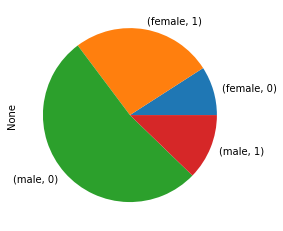

In [23]:
training_data.groupby(['Sex','Survived']).size().plot.pie()

We can choose to zoom in on one of the classes only

In [24]:
training_data[training_data['Sex']=='male'].groupby(['Sex','Survived']).size().unstack('Survived')

Survived,0,1
Sex,,
male,468,109


Lets also visualize it

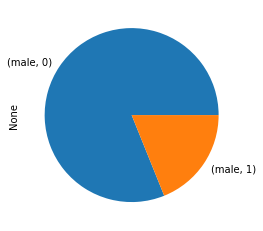

In [25]:
training_data[training_data['Sex']=='male'].groupby(['Sex','Survived']).size().plot.pie()

Alternatively, we can do a stacked bar chart

,1,2,3
Did not survived,0.089787,0.108866,0.417508
Survived,0.152637,0.097643,0.133558


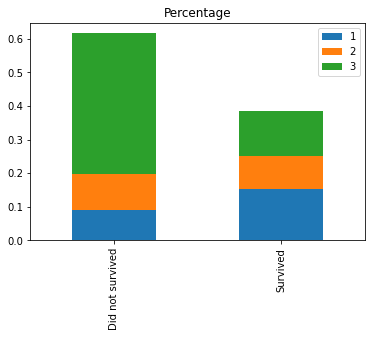

In [26]:
def survival_stacked_bar(df,feature):
    # Get the percentage of people that didn't survive per class in the feature given
    didnt_survive=training_data[df["Survived"]==0][feature].value_counts()/len(df["Survived"]==0)
    
    # Get the percentage of people that survived per class in the feature given
    survived=df[df["Survived"]==1][feature].value_counts()/len(df["Survived"]==1)
    
    # Create a dataframe of both of them 
    data=pd.DataFrame([didnt_survive,survived])
    data.index=["Did not survived","Survived"]
    
    # Plot it
    data.plot(kind="bar",stacked=True,title="Percentage")
    return data.head()

survival_stacked_bar(training_data,'Pclass')

We imputed the feature 'Embarked' (Categorical) with most frequent class, now lets try to impute age (Numerical) using Pandas powerful function, interpolate()

In [27]:
training_data['Age'] = training_data['Age'].interpolate()

We can get the Correlation between the features and the target

In [28]:
training_data.apply(lambda x: x.factorize()[0]).corr()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
Survived,1.000000,0.247845,0.543351,-0.020687,-0.136302,0.086210,0.191981,0.106811
Pclass,0.247845,1.000000,0.118133,-0.012922,-0.149630,-0.000343,0.079498,-0.168091
Sex,0.543351,0.118133,1.000000,-0.029155,-0.046152,0.242417,0.137725,0.116569
Age,-0.020687,-0.012922,-0.029155,1.000000,0.050835,0.013401,0.103397,0.119561
SibSp,-0.136302,-0.149630,-0.046152,0.050835,1.000000,0.165255,-0.046556,-0.030683
Parch,0.086210,-0.000343,0.242417,0.013401,0.165255,1.000000,0.074306,-0.085059
Fare,0.191981,0.079498,0.137725,0.103397,-0.046556,0.074306,1.000000,0.076726
Embarked,0.106811,-0.168091,0.116569,0.119561,-0.030683,-0.085059,0.076726,1.000000


Visualize it with a heatmap

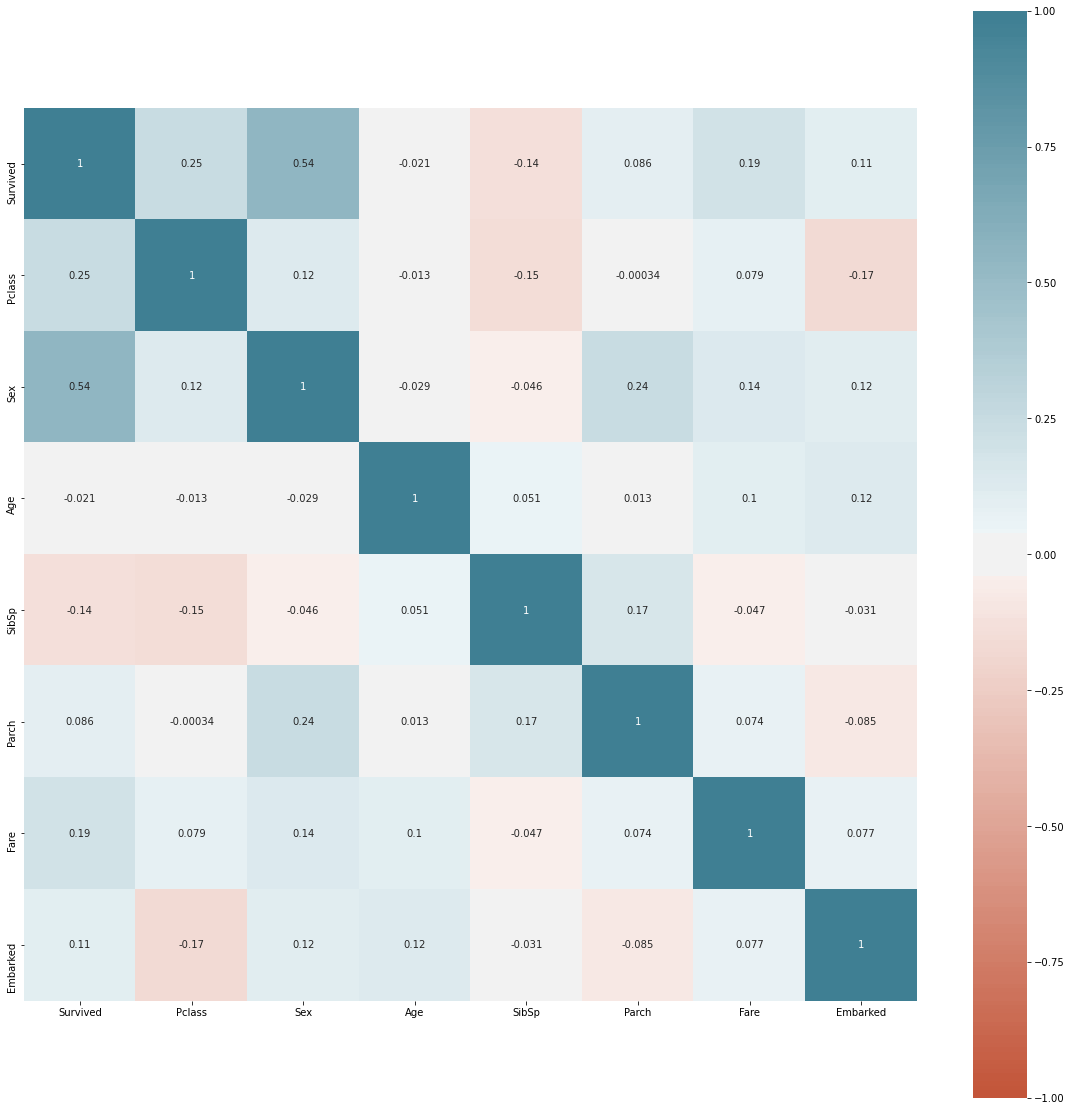

In [29]:
plt.figure(figsize=(20,20))
sns.heatmap(training_data.apply(lambda x: x.factorize()[0]).corr(), 
    vmin=-1, 
    vmax=1, 
    center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True);

# Handling Quantitative (Numerical) Data

## Feature Scaling

#### MinMax Scaling

In [30]:
# Get current Min and Max value of Age
print("Age Min: ", training_data['Age'].min())
print("Age Max: ", training_data['Age'].max())
training_data[['Age']].head()

Age Min:  0.42
Age Max:  80.0


,Age
0,22.0
1,38.0
2,26.0
3,35.0
4,35.0


In [31]:
# Create MinMax Scaler
minmax_scaler = preprocessing.MinMaxScaler()

# Scale feature using MinMaxScaler
training_data['Age']=minmax_scaler.fit_transform(training_data[['Age']])

print("Age Min: ", training_data['Age'].min())
print("Age Max: ", training_data['Age'].max())
training_data[['Age']].head()

Age Min:  0.0
Age Max:  1.0


,Age
0,0.271174
1,0.472229
2,0.321438
3,0.434531
4,0.434531


In [32]:
# Invert MinMax Scaling because we won't be needing it for now
training_data['Age']=minmax_scaler.inverse_transform(training_data[['Age']])
training_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


#### Feature Standardization

In [33]:
# Get current Mean and Standard Deviation of Fare
print("Fare Mean: ", training_data['Fare'].mean())
print("Fare Standard Deviation: ", training_data['Fare'].std())
training_data[['Fare']].head()

Fare Mean:  32.204207968574636
Fare Standard Deviation:  49.6934285971809


,Fare
0,7.2500
1,71.2833
2,7.9250
3,53.1000
4,8.0500


In [34]:
# Create Standardization Scaler
standard_scaler = preprocessing.StandardScaler()

# Scale the feature using Standardization Scaler
training_data['Fare'] = standard_scaler.fit_transform(training_data[['Fare']])

print("Fare Mean: ", training_data['Fare'].mean())
print("Fare Standard Deviation: ", training_data['Fare'].std())
training_data[['Fare']].head()

Fare Mean:  3.987332972840069e-18
Fare Standard Deviation:  1.0005616400330457


,Fare
0,-0.502445
1,0.786845
2,-0.488854
3,0.420730
4,-0.486337


In [35]:
# # Invert Standardization Scaling
# training_data['Fare'] = standard_scaler.inverse_transform(training_data[['Fare']])

## Feature Discretization

In [36]:
# Creating bins from 0 to maximum value of Age
bins = np.linspace(0, training_data['Age'].max(), 11)
print(bins)
training_data['AgeBins']=pd.cut(x=training_data['Age'], bins=bins, labels=range(1,11))
training_data[['Age','AgeBins']]

[ 0.  8. 16. 24. 32. 40. 48. 56. 64. 72. 80.]


,Age,AgeBins
0,22.0,3
1,38.0,5
2,26.0,4
3,35.0,5
4,35.0,5
...,...,...
886,27.0,4
887,19.0,3
888,22.5,3
889,26.0,4


In [37]:
# Removing the AgeBins column cause we wont be using it.
training_data.drop(columns=['AgeBins'], inplace=True)

## Clustering Data Points

In [38]:
# Make k-means clusterer
clusterer = KMeans(5, random_state=0)

# Fit clusterer
clusterer.fit(training_data[['Pclass','SibSp','Parch']])

# Predict values
training_data["Groups"] = clusterer.predict(training_data[['Pclass','SibSp','Parch']])
training_data[['Pclass','SibSp','Parch',"Groups"]].head(20)

,Pclass,SibSp,Parch,Groups
0,3,1,0,1
1,1,1,0,3
2,3,0,0,4
3,1,1,0,3
4,3,0,0,4
5,3,0,0,4
6,1,0,0,3
7,3,3,1,0
8,3,0,2,2
9,2,1,0,1


In [39]:
# Removing the Groups column cause we wont be using it.
training_data.drop(columns=['Groups'], inplace=True)

# Handling Outliers

There are many ways to handle outliers, the most basic one is to check for outliers using a boxplot which uses *Inter-Quartile Range* to detect the outliers.

The way it works is similar to the following:
- Sort the feature in increasing order
- Find the first quartile (q1) and third quartile (q3)
- Find Inter-Quartile Range (IQR) = q3 - q1
- Find the lower bound = (q1 - (1.5 * IQR)) 
- Find the upper bound = (q3 + (1.5 * IQR))

Anything that lies above or below the the lower bound or the upper bound is an outlier.  
The plot shows the quartiles as whiskers as shown below, the single line in the middle of the box would be the median

Text(0.5, 1.0, 'Boxplot')

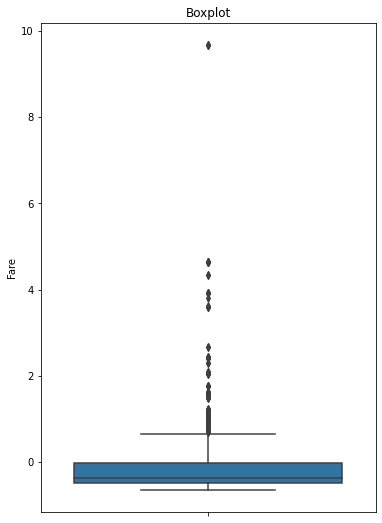

In [40]:
# boxplot
plt.figure(figsize=(6,9))
sns.boxplot(y=training_data['Fare'])
plt.title('Boxplot')

IF we choose to remove the the outliers (we won't, we barely have enough data and these are not outliers we want to remove anyway), we can just replicate what the boxplot does 

In [41]:
# Get Q1, Q3, and IQR
Q1 = training_data['Fare'].quantile(0.25)
Q3 = training_data['Fare'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds conditions
outliers_filter = (training_data['Fare'] >= Q1 - (1.5 * IQR)) & (training_data['Fare'] <= Q3 + (1.5 *IQR))

# Data without outliers
training_data.loc[outliers_filter]  

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,-0.502445,S
2,1,3,female,26.0,0,0,-0.488854,S
3,1,1,female,35.0,1,0,0.420730,S
4,0,3,male,35.0,0,0,-0.486337,S
5,0,3,male,44.5,0,0,-0.478116,Q
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,-0.386671,S
887,1,1,female,19.0,0,0,-0.044381,S
888,0,3,female,22.5,1,2,-0.176263,S
889,1,1,male,26.0,0,0,-0.044381,C


# Handling Qualitative (Categorical) Data

## Encoding Nominal Features  

We can easily apply One-Hot Encoding on Embarked

In [42]:
training_data = pd.concat([training_data, pd.get_dummies(training_data["Embarked"])], axis=1)

training_data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,C,Q,S
0,0,3,male,22.0,1,0,-0.502445,S,0,0,1
1,1,1,female,38.0,1,0,0.786845,C,1,0,0
2,1,3,female,26.0,0,0,-0.488854,S,0,0,1
3,1,1,female,35.0,1,0,0.420730,S,0,0,1
4,0,3,male,35.0,0,0,-0.486337,S,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,-0.386671,S,0,0,1
887,1,1,female,19.0,0,0,-0.044381,S,0,0,1
888,0,3,female,22.5,1,2,-0.176263,S,0,0,1
889,1,1,male,26.0,0,0,-0.044381,C,1,0,0


In [43]:
training_data = pd.concat([training_data, pd.get_dummies(training_data["Sex"])], axis=1)
training_data.drop(columns=['Sex','male'], inplace=True)
training_data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,C,Q,S,female
0,0,3,22.0,1,0,-0.502445,S,0,0,1,0
1,1,1,38.0,1,0,0.786845,C,1,0,0,1
2,1,3,26.0,0,0,-0.488854,S,0,0,1,1
3,1,1,35.0,1,0,0.420730,S,0,0,1,1
4,0,3,35.0,0,0,-0.486337,S,0,0,1,0


## Encoding Ordinal Features  

Unfortunately, the only Ordinal Feature we have is Pclass but it is already numerical.  
So instead, let's say, hypothatically, that where you embarked from matters somehow, maybe it points to your social status.

In [44]:
# class_mapping = {"S": 1, "C" :2, "Q":3}
# training_data["Embarked"] = training_data["Embarked"].replace(class_mapping)

In [45]:
# training_data[['Embarked','S', 'C', 'Q']]

# Adding New Features

Adding new features all depends on your Business Understanding and Data Understanding.  
what features can you think of that can give you a better predicition?  

An example would be to add two features:
- A feature that tells us if someone has a family or not
- A feature that tells us if someone is an adult or not

In [46]:
training_data['HasFamily']=(training_data['SibSp'] + training_data['Parch']).apply(lambda x: 1 if x > 0 else 0)

In [47]:
training_data['Adult']=training_data['Age'].apply(lambda x: 1 if x > 17 else 0)

Lets drop the features we used to construct the new features

In [48]:
training_data.drop(columns=['SibSp','Parch','Age','Embarked'], inplace=True)

In [49]:
training_data

,Survived,Pclass,Fare,C,Q,S,female,HasFamily,Adult
0,0,3,-0.502445,0,0,1,0,1,1
1,1,1,0.786845,1,0,0,1,1,1
2,1,3,-0.488854,0,0,1,1,0,1
3,1,1,0.420730,0,0,1,1,1,1
4,0,3,-0.486337,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...
886,0,2,-0.386671,0,0,1,0,0,1
887,1,1,-0.044381,0,0,1,1,0,1
888,0,3,-0.176263,0,0,1,1,1,1
889,1,1,-0.044381,1,0,0,0,0,1


Now let's save our new data as a CSV file and use it as input to build a Machine Learning Model

In [50]:
training_data.to_csv('training_prepared.csv',index=False)

Developed by Amro.Moustafa@ibm.com